## Introduction

The Deltaflow language offers the ability to subdivide algorithms into their base parts,
and provides the runtime facility to efficiently implement them on relevant hardware.
Adaptive, NISQ algorithms such as the
[Accelerated Variational Quantum Eigensolver](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.122.140504)
or [Engineered Likelihood Functions](https://arxiv.org/abs/2006.09350) have been specifically
developed with fast communication between hardware components in mind.
However, even certain implementations of simpler algorithms such as
[VQE](https://www.nature.com/articles/ncomms5213) can benefit from in-situ
calculations between quantum circuit executions.
Here we explore the first steps towards implementing an algorithm like VQE
in the Deltaflow language.

This notebook is intended to show how one would move from a python implementation
of an algorithm to a Deltaflow implementation.
In reality, certain components of the instructions below would be supplanted
by real quantum hardware or FPGA nodes.
We abstract these details out in order to showcase a use-case of the Deltaflow language.

We will start with the definition of our problem and a simple python impementation,
before extending this to be incorporated into `DeltaGraph`.
We believe only minor modifications would be needed to use the example
below for a much more complex problem, however integrating these to interact
with real hardware requires more advanced node workings. 

$$\newcommand{\braket}[2]{\left\langle {#1} \middle| {#2} \right\rangle}$$ 
$$\newcommand{\brakett}[3]{\left\langle {#1} \middle| {#2} \middle| {#3} \right\rangle}$$
$$\newcommand{\ket}[1]{\left| {#1} \right\rangle}$$

## Theory

### Variational Quantum Eigensolver (VQE)

<div>
<img src="VQE_structure_original.jpg" width="500"/>
</div>

Current quantum hardware suffers from low qubit coherence times and compiling
error rates in deep circuits.
While the hardware is continually improving, realising fault-tolerant quantum
computers is not likely within the next two decades.
In order to extract useful calculations from these noisy, low-depth quantum
machines the variational quantum eigensolver was devised.
Using the variational principle, this algorithm utilises low-depth quantum
circuits to complement a classical optimisation procedure, as can be seen
in the diagram above (kindly borrowed from the original reference). 

Specifically, if we consider a problem Hamiltonian $H = \sum_i a_iP_i$ where
$a_i$ are known complex coefficients and $P_i$ are Pauli matrix strings,
the goal is to find the ground state of energy of $H$.
Using a physically-inspired ansatz wavefunction $\ket{\psi(\lambda)}$,
parameterized by a real-valued $\lambda$ and generated by preparation
circuit $R$ such that $\ket{\psi(\lambda)}\equiv R(\lambda)\ket{0}$,
we can write the energy of the system as:

$$\langle H\rangle = E(\lambda) = \sum_ia_i\brakett{\psi(\lambda)}{ P_i}{\psi(\lambda)}.$$

Such that we need only calculate individual expectation values
$A_i = \brakett{\psi(\lambda)}{P_i}{\psi(\lambda)}$. 


VQE calculates these values $A_i$ through it's subroutine Quantum Expectation
Estimation, briefly explained below.
Alternatives such as AVQE or ELF, as mentioned in the introduction, achieve
the same goal through implementing different quantum subroutines.
That is to say the input ansatz circuit and desired Pauli, as well as the
output measurement outcome(s), do not vary across algorithms aiming to
calculate the ground state energy of some Hamiltonian.

In VQE these subroutine circuits have depth $O(1)$.
However, to reach a precision $p < 1$ they each have to be executed
$O(p^{-2})$ times which can be restrictive.
Once each $A_i$ has been calculated, the energy $E(\lambda)$ is calculated
and passed to a classical optimisation routine;
this updates the value of $\lambda$ and the algorithm loops.
The exit criteria is when we have reached a pre-determined precision on $E$.

The classical outer-loop grants a degree of freedom in how the optimisation
is actually performed over the $\lambda$ parameter space, however the
implementation of the quantum subroutine -
known as Quantum Expectation Estimation - requires more in-depth focus.

### Quantum Expectation Estimation (QEE)

The quantum subroutine of VQE utilises Hamiltonian averaging to generate
information about the target quantity, the overlap
$A=\brakett{\psi(\lambda)}{P}{\psi(\lambda)}$ where the subsystem index
$i$ has been dropped.
For a single qubit, the example we consider here, this method is quite straightforward.
Given a prepared quantum state $|\psi(\lambda)\rangle$ we want to know
the outcome when measuring Pauli $P$.
Converting into the eigenbasis of $P$ we can write:

$$\ket{\psi(\lambda)} = \left(\frac{I+P}{2}\right)\ket{\psi} + \left(\frac{I-P}{2}\right)\ket{\psi}.$$

The probability of observing an eigenvalue of $+1$ or $-1$ is then the absolute square value of
the first and second terms in the eigen-decomposition above, respectively:

$$p_{+1} = \frac{1 + A}{2}, \hspace{12pt} p_{-1} = \frac{1-A}{2}$$

Therefore, by repeatedly preparing this ansatz state, measuring
the $P$ matrix and recording the outcomes we can make an accurate
prediction of these probabilities and then simply re-arrange for
the value of $A$. 

It is important to note that an eigenvalue of $+1$ corresponds 
to observing the eigenvector $\ket{0}$ in the $Z$-basis --- the computational basis
for quantum computers. The quantum simulator we employ here, [ProjectQ](https://projectq.ch/),
returns a bitstring of 0's and 1's corresponding to the quantum states observed. 
For a single qubit, if ProjectQ returns a $0$ we must increase our $p_{+1}$ defined above. 

## Implementations

### Example 1: QEE in Python

To gain some intuition about the behaviour of this subroutine, here we will
show a python implementation and then the same code modified to accommodate
the Deltaflow language. 

For this purpose, we will consider only a basic single-gate ansatz circuit
acting on one qubit.
For a single qubit wavefunction $|\psi\rangle = R_x(\theta)|0\rangle$
measuring the Pauli matrix $Z$ gives us an expectation value of 

$$E = \brakett{\psi}{R_x^\dagger(\theta) Z  R_x(\theta)}{\psi} = \cos(\theta)$$

Note: The `p_one` variable used throughout corresponds to the probability
of seeing an *eigenvector* $\ket{1}$ from (simulated) quantum hardware. 
From our definitions above, `p_one`$\equiv p_{-1} = \left(1-A\right)/2$.
Therefore the estimated expectation value `estimate` will be calculated as A = `1 - 2*p_one`.

We use `ProjectQ` as a backend for this implementation, but you can try to
replace this node by any other quantum circuit simulator.

*Let's also save ourseves from repeating the same code twice and decorate
this function with `DeltaBlock` right away, as it will by reused in
the Deltalanguage implementation in the next section.*

In [1]:
from projectq import MainEngine 
from projectq.ops import Rx, Z, Measure

import deltalanguage as dl


@dl.DeltaBlock()
def circuit(theta: float) -> int:
    """A simple quantum circuit with 1 parametrized gate."""
    engine = MainEngine()
    qubit = engine.allocate_qubit()

    Rx(theta) | qubit
    Z | qubit
    Measure | qubit
    engine.flush()

    return int(qubit)

We need to repeat the above circuit a number of times to achieve the required
precision $p$ - typically $O(1/p^2)$ times.

Let us crack on and see how the QEE implementation will look like:

In [2]:
import numpy as np


def QEE_py(precision, theta):
    """Quantum Expectation Estimation in Python."""
    print(f"Starting QEE routine with theta={theta}, precision={precision}:")

    p_one = 0
    estimates = []
    runs = 0

    while True:
        runs += 1

        # Run quantum cirquit and gather statistic
        measurement_outcome = circuit(theta)

        p_one += measurement_outcome
        estimate = 1 - 2*p_one/runs
        estimates.append(estimate)
        std = np.std(estimates)

        # Accumulate statistic of at least 100 runs
        if runs < 100:
            continue

        if runs%500 == 0:
            print(f'    Run {runs:5d}, std={std:.5f}')

        if std <= precision:
            break
           
    print(f'Exiting after {runs} runs with std={std:.5f}')

    return np.mean(estimates), std, runs

Choose the parameters, by increasing/decreasing `p` we will decrease/increase the simulation time,
e.g. $p = 10^{-3}$ will need $O(1/p^2) = 10^6$ circuit executions before exiting.

In [3]:
# These constants will be used throughout this example
THETA = np.pi/3
PRECISION = 0.1

mean, std, runs = QEE_py(PRECISION, THETA)
true_value = np.cos(THETA)

print(f'\nTrue value = {true_value:.5f} for theta = {THETA:.5f}')
print(f'Final estimation value: {mean:.5f}')
print(f'Error: {abs(true_value - mean):.5f}')
print(f'Standard Deviation of measurements: {std:.5f}')

Starting QEE routine with theta=1.0471975511965976, precision=0.1:
Exiting after 212 runs with std=0.09986

True value = 0.50000 for theta = 1.04720
Final estimation value: 0.31324
Error: 0.18676
Standard Deviation of measurements: 0.09986


### Example 2: QEE in Deltalanguage

Given the Python code above, how would we go about implementing this in Deltalanguage?
First, take a look at the necessary components that will be used below:

- `DeltaBlock`, `Interactive` allow us to create Deltaflow nodes;

- `DeltaGraph` is necessary for us to wire up the nodes;

- `make_forked_return` will allow us to extract multiple outputs from a node and
    direct them to different destinations;

- `placeholder_node_factory` is needed to resolve circular dependency in the graph;

- `StateSaver` allows us to store and save the result for further comparison;

- `DeltaPySimulator` and `DeltaRuntimeExit` allow us to simulate and exit graphs respectively.

The original QEE function used in the example above can be used
in this implementation as well, however it will require rethinking
the data flow in the graph and will be just unnecessarily complicated.
Instead we give a new definition via the `Interactive` Deltaflow
wrapper, which is perfectly suited for such tasks.

This new node will be sending data to two other nodes, thus
initially we define the return `type` and `class` pair:

- the first output will contain the final result bundled together in a tuple:
    - mean, `float`
    - standard deviation, `float`
    - the total number of runs, `int`

- the second output is used for the circuit parametrization, `float`

In [4]:
QEEOutT, QEEOutC = dl.make_forked_return({'result': dl.DTuple([float, float, int]),
                                          'theta': float})

Now let's define the function itself, note that each time data is received we should use the
`node.receive` method and when it's sent out, `node.send`.
Everything else is the same as in the original QEE!

In [5]:
@dl.Interactive(in_params={"precision": float,
                           "theta": float,
                           "measurement": int},
                out_type=QEEOutT)
def QEE_df(node):
    """Quantum Expectation Estimation in Deltalanguage."""
    # NEW: receive QEE parameters in the infinite loop
    while True:
        precision = node.receive("precision")
        theta = node.receive("theta")
        
        print(f"Starting QEE: theta/pi={theta/np.pi:.5f}, precision={precision}:")

        p_one = 0
        estimates = []
        runs = 0

        while True:
            runs += 1

            # NEW: send angle to the quantum circuit and wait for results
            node.send(QEEOutC(result=None, theta=theta))
            measurement = node.receive("measurement")

            p_one += measurement
            estimate = 1 - 2*p_one/runs
            estimates.append(estimate)
            std = np.std(estimates)

            # Accumulate statistic of at least 100 runs
            if runs < 100:
                continue

            if runs%500 == 0:
                print(f'    Run {runs:5d}, std={std:.5f}')

            if std <= precision:
                break
            
        print(f'Exiting after {runs} runs with std={std:.5f}','\n')

        # NEW: send out the final result for this QEE parameters
        node.send(QEEOutC(result=(np.mean(estimates), std, runs), theta=None))

We can now build `DeltaGraph`, making use of 
`placeholder_factory_node` to ensure proper connectivity.

The `StateSaver` instance will record the result in a list that
can be accessed once the Deltaflow program has completed;
it also ensures that the graph exits once a result has been found. 

In [6]:
s = dl.lib.StateSaver(object, verbose=False)

with dl.DeltaGraph() as graph:
    qee_ph = dl.placeholder_node_factory()

    circuit_out = circuit(theta=qee_ph.theta)
    s.save_and_exit(qee_ph.result)

    qee_ph.specify_by_node(QEE_df.call(precision=PRECISION,
                                       theta=THETA,
                                       measurement=circuit_out))

print(graph)

DeltaGraph[main] {
    node[circuit_0]:
        ports:
            in:
                theta, DFloat32
            out:
                output, DInt32 -> QEE_df_4.measurement
        bodies:
            *PyFuncBody
                tags: circuit

    node[save_and_exit_1]:
        ports:
            in:
                val, T
        bodies:
            *PyFuncBody
                tags: save_and_exit

    node[node_2]:
        ports:
            out:
                output, DFloat32 -> QEE_df_4.precision
        bodies:
            *PyConstBody
                tags: <lambda>

    node[node_3]:
        ports:
            out:
                output, DFloat32 -> QEE_df_4.theta
        bodies:
            *PyConstBody
                tags: <lambda>

    node[QEE_df_4]:
        ports:
            in:
                precision, DFloat32
                theta, DFloat32
                measurement, DInt32
            out:
                theta, DFloat32 -> circuit_0.theta
                resul

It might be more intuitive to look at the graph's visualisation:

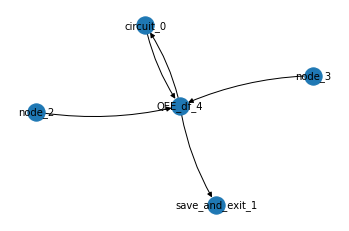

In [7]:
graph.draw(seed=1)

Now that the graph has been compiled, we're ready to evaluate it.
We use a simple python simulator that does not provide high performance
but ensures the correctness on the execution:

In [8]:
rt = dl.DeltaPySimulator(graph)
rt.run()

# Extract the latest saved results:
mean, std, runs = s.saved[-1]

assert std < PRECISION

Starting QEE: theta/pi=0.33333, precision=0.1:
Exiting after 146 runs with std=0.09977 

Starting QEE: theta/pi=0.33333, precision=0.1:


### Example 3: VQE in Deltalanguage

Now we have a Deltaflow graph that implements QEE (a subroutine of VQE),
we can complete the entire algorithm.

All that remains is to wire up an optimisation
outer-loop to pass various ansatz parameters to the subroutine.
To illustrate how this could be done, we will forgo the optimisation
step and instead simply pass individual ansatz parameters,
finding the expectation value at each. 

This new node takes the results of QEE as an input, aggregate
the mean and standard deviation values, and save them for future
plotting.

Besides that we provide a set of parameters to define the range
of `theta` as global constants.

In [9]:
AnsatzOutT, AnsatzOutC = dl.make_forked_return({'results': object,
                                                'theta': float})

@dl.Interactive(in_params={"result": dl.DTuple([float, float, int])},
                out_type=AnsatzOutT)
def ansatz(node):
    maen_list, std_list, runs_list = [], [], []

    for theta in np.linspace(THETA_MIN, THETA_MAX, THETA_NUM):
        node.send(AnsatzOutC(results=None, theta=theta))
        mean, std, runs = node.receive("result")
        maen_list.append(mean)
        std_list.append(std)
        runs_list.append(runs)

    node.send(AnsatzOutC(results=(maen_list, std_list), theta=None))

Let's connect the graph:

In [10]:
with dl.DeltaGraph() as graph:
    qee_ph = dl.placeholder_node_factory()

    circuit_out = circuit(theta=qee_ph.theta)

    anzatz_out = ansatz.call(result=qee_ph.result)

    qee_ph.specify_by_node(QEE_df.call(precision=PRECISION,
                                       theta=anzatz_out.theta,
                                       measurement=circuit_out))
    
    s.save_and_exit(anzatz_out.results)

print(graph)

DeltaGraph[main] {
    node[circuit_5]:
        ports:
            in:
                theta, DFloat32
            out:
                output, DInt32 -> QEE_df_8.measurement
        bodies:
            *PyFuncBody
                tags: circuit

    node[ansatz_6]:
        ports:
            in:
                result, (DFloat32, DFloat32, DInt32)
            out:
                theta, DFloat32 -> QEE_df_8.theta
                results, T -> save_and_exit_9.val
        bodies:
            *PyInteractiveBody
                tags: ansatz

    node[node_7]:
        ports:
            out:
                output, DFloat32 -> QEE_df_8.precision
        bodies:
            *PyConstBody
                tags: <lambda>

    node[QEE_df_8]:
        ports:
            in:
                precision, DFloat32
                theta, DFloat32
                measurement, DInt32
            out:
                theta, DFloat32 -> circuit_5.theta
                result, (DFloat32, DFloat32, DInt32) ->

The flow of data becomes ever slightly more complicated:

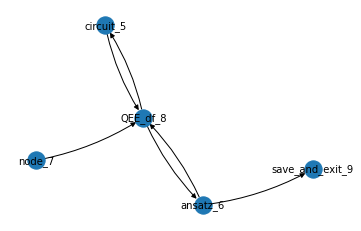

In [11]:
graph.draw(seed=9)

Now we can simulate the graph with provided parameters:

In [12]:
THETA_MIN = 0
THETA_MAX = 2*np.pi
THETA_NUM = 15

rt = dl.DeltaPySimulator(graph)
rt.run()

Starting QEE: theta/pi=0.00000, precision=0.1:
Exiting after 100 runs with std=0.00000 

Starting QEE: theta/pi=0.14286, precision=0.1:
Exiting after 100 runs with std=0.01797 

Starting QEE: theta/pi=0.28571, precision=0.1:
Exiting after 128 runs with std=0.10000 

Starting QEE: theta/pi=0.42857, precision=0.1:
Exiting after 263 runs with std=0.09992 

Starting QEE: theta/pi=0.57143, precision=0.1:
Exiting after 110 runs with std=0.09966 

Starting QEE: theta/pi=0.71429, precision=0.1:
    Run   500, std=0.12501
    Run  1000, std=0.10589
Exiting after 1246 runs with std=0.09999 

Starting QEE: theta/pi=0.85714, precision=0.1:
Exiting after 100 runs with std=0.08706 

Starting QEE: theta/pi=1.00000, precision=0.1:
Exiting after 100 runs with std=0.00000 

Starting QEE: theta/pi=1.14286, precision=0.1:
Exiting after 261 runs with std=0.09987 

Starting QEE: theta/pi=1.28571, precision=0.1:
Exiting after 137 runs with std=0.09989 

Starting QEE: theta/pi=1.42857, precision=0.1:
Exiting 

The slow performance around $\theta = \pi/2$ and $3\pi/2$ is expected as this corresponds to an expectation value of $\langle A\rangle=0$. The algorithm struggles to converge on these points as the probability is exactly $1/2$ for both outcomes from the quantum simulator. Conversely, when $\theta = 0$ ($\pi$) the outcome will always be 1 (0) result in zero variance.

Let's assert some basic tests:

In [13]:
mean_list, std_list = s.saved[-1]

assert len(mean_list) == THETA_NUM and len(std_list) == THETA_NUM
assert all(map(lambda x: x < PRECISION, std_list))

And compare the resul
t with the true values:

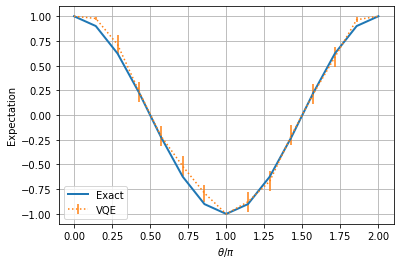

In [14]:
import matplotlib.pyplot as plt


theta_list = np.linspace(THETA_MIN, THETA_MAX, THETA_NUM)

plt.plot(theta_list/np.pi, np.cos(theta_list), linewidth = 2, label='Exact')
plt.errorbar(theta_list/np.pi, mean_list, std_list, linestyle=':', label='VQE')
plt.ylabel('Expectation')
plt.xlabel(r'$\theta/\pi$')
plt.grid(True)
plt.legend()
plt.show()

## Conclusions

The above examples showed how a basic VQE code can be adopted to the shape
of a distributed graph of asyncronous processes, which makes it
portable to real experimental setups via Deltaruntime or
advanced simulation platforms via Deltasimulator.

The crucial point to get from this is that by going from a procedural language,
such as Python, to a dataflow language, such as Deltalanguage, requires
redesign of the algorithm structure.
We hope that by providing this implementation we have helped with
these initial steps.

Implementing a more complicated ansatz with more parameters,
an optimisation routine, and a more complex Hamiltonian with multiple Pauli
terms are all minor modifications.
A more complex algorithm, such as Accelerated VQE, would require another function
to perform intermediate calculations in between circuit executions, adding another
node to our graph.